# Redes Recurrentes en Reconocimiento de Acciones




En este notebook veremos como implementar redes neuronales recurentes para reconocer la *actividad* o *acción* que una persona se encuentra ejecutando a partir de datos recogidos de sensores disponibles en un teléfono. 
 


<table align='left'>
<tr>
<td><img width='550'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/AR_pic.jpg'></td>
<td><img width='400'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/wearable_TEG.png'></td>
</tr>
</table>


Como hemos explicado en los videos, una red neuronal recurrente es un modelo especializado en el procesamiento de secuencias: series de tiempo, frases en lenguaje natural, videos, etc. Puede ocurrir que tanto el input como el output del modelo sean secuencias (por ejemplo: traducción), que sólo el input sea una secuencia (por ejemplo: clasificación de un video) o que sólo el output sea una secuencia (por ejemplo: descripción en lenguaje natural de una imagen).

En nuestro problema, las secuencias corresponden a las señales recogidas desde los sensores del teléfono y la salida es la acción que la persona está ejecutando. Esta es una aplicación donde nos esperamos que sea toda la secuencia de valores registrados por el sensor la que determine la acción, y no un valor o atributo específico. 

Se trata además de un problema en que (1) es muy difícil diseñar manualmente atributos que permitan hacer la clasificación, (2) es muy difícil diseñar manualmente las reglas/ecuaciones que relacionan la señal con cada actividad.


# Datos

Usaremos datos recolectados por colegas de la Universidad de Génova y descritos en el paper de más abajo.

> Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. *A public domain dataset for human activity recognition using smartphones*. 2013.

El dataset fue obtenido con un grupo de voluntarios a quienes se les pidió ejecutar 6 acciones diferentes (2 veces): 

1.   Pararse (standing)
2.   Sentarse (sitting)
3.   Acostarse (laying down)
4.   Caminar (walking)
5.   Subir una Escalera (walking downstairs)
6.   Bajar una Escalera (walking upstairs)

Los movimientos fueron registrados usando el *acelererómetro* y el *giroscopio* de un smartphone instaladado alrededor de la cintura de cada persona. El acelerómetro entrega 3 señales: la aceleración (cambio de velocidad) en las direcciones $x$, $y$ y $z$ (cada uno de los 3 ejes cartesianos). Estas 3 señales se suelen descomponer en 2 partes: el cambio debido a la gravedad y la aceleración debida al movimiento del cuerpo propiamente tal. De este modo, se obtienen en realidad 6 señales usando el acelererómetro. Por otro lado, el giroscopio entrega información respecto a la orientación del cuerpo en el tiempo, de modo que se tienen 3 señales correspondientes a las direcciones $x$, $y$ y $z$.  




<table align='left'>
<tr>
<td><img width='450'  align='left' src='https://miro.medium.com/max/4266/0*bS8im7IxVmW4DK9o.jpg'></td>
</tr>
</table>

Las diferentes señales se muestrearon a una frecuencia de 50Hz (50 datos por segundo) usando ventanas de 2.56 segundos, lo que genera secuencias de largo 128. En total, este procedimiento produjo 10299 de secuencias de 9 atributos cada una (giroscopio x3 y acelerómetro x 6), clasificadas en 1 de las 6 posibles categorías. Típicante un 70% de los datos (7352 sequencess) se reserva para entrenamiento y un 30% para pruebas (2947 sequences). Para hacer el experimento más realista el conjunto de pruebas incluye movimientos ejecutados por personas no incluidas en el conjunto de entrenamiento.


# Herramientas

Como en experiencias anteriores, usaremos el ecosistema básico de Python (numpy, matplotlib) y una librería de alto nivel muy conocidas para deep learning: keras. 

<table align='left'>
<tr>
<td><img src='https://www.insidevcode.eu/wp-content/uploads/2015/05/python-logo.png' width='380'/></td>
<td><img src='http://jricardon.github.io/BBS19lab2Files/figs/keras_logo.png' width='350'/></td>
</tr>
</table>

In [ ]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

# Carga de Datos y Visualización

## Descarga

El código de más abajo descarga los datos de mi Github a la máquina local.


In [ ]:
!wget http://www.inf.utfsm.cl/~jnancu/activity/list_of_files_HAR.txt -O \
   /tmp/list_of_files_HAR.txt

!wget --no-check-certificate -i /tmp/list_of_files_HAR.txt
  

--2021-06-23 23:39:05--  http://www.inf.utfsm.cl/~jnancu/activity/list_of_files_HAR.txt
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.inf.utfsm.cl/~jnancu/activity/list_of_files_HAR.txt [following]
--2021-06-23 23:39:06--  https://www.inf.utfsm.cl/~jnancu/activity/list_of_files_HAR.txt
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235 (1.2K) [text/plain]
Saving to: ‘/tmp/list_of_files_HAR.txt’

/tmp/list_of_files_ 100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-06-23 23:39:06 (224 MB/s) - ‘/tmp/list_of_files_HAR.txt’ saved [1235/1235]

URL transformed to HTTPS due to an HSTS policy
--2021-06-23 23:39:06--  https://www.inf.utfsm.cl/~jnancu/activity/classes_test.txt
Resolving www.inf.utfsm.cl (www.inf

## Lectura

En esta sección leemos los archivos de datos para organizarlos en un tensor/arreglo apropiado para el aprendizaje sobre secuencias. Como las series son todas de largo 128 y tenemos 9 atributos en cada tiempo, el tensor de entrenamiento debiese tener forma 7352 x 128 x 9 y el de pruebas 2947 x 128 x 9.


In [ ]:
from pandas import read_csv
import numpy as np


def load_data(subset='train', folder=''):
  
  filenames = list()
  filenames += ['total_acc_x_'+subset+'.txt', 'total_acc_y_'+subset+'.txt', 'total_acc_z_'+subset+'.txt']
  filenames += ['body_acc_x_'+subset+'.txt', 'body_acc_y_'+subset+'.txt', 'body_acc_z_'+subset+'.txt']
  filenames += ['body_gyro_x_'+subset+'.txt', 'body_gyro_y_'+subset+'.txt', 'body_gyro_z_'+subset+'.txt']
  
  X = list()
  
  for filen in filenames:
    
    print("Loading Features %s"%filen)
    data = read_csv(folder+filen, header=None, delim_whitespace=True).values
    print(data.shape)
    X.append(data)
    
    
  Y = read_csv(folder+'classes_'+subset+'.txt', header=None, delim_whitespace=True).values
  Y = Y - 1
  X = np.dstack(X)
  
  return X,Y

X_train,Y_train = load_data('train','')
print("Formas Tensores de Entrenamiento: ", X_train.shape,Y_train.shape)

X_test,Y_test = load_data('test','')
print("Formas Tensores de Pruebas: ", X_test.shape,Y_test.shape)


Loading Features total_acc_x_train.txt
(7352, 128)
Loading Features total_acc_y_train.txt
(7352, 128)
Loading Features total_acc_z_train.txt
(7352, 128)
Loading Features body_acc_x_train.txt
(7352, 128)
Loading Features body_acc_y_train.txt
(7352, 128)
Loading Features body_acc_z_train.txt
(7352, 128)
Loading Features body_gyro_x_train.txt
(7352, 128)
Loading Features body_gyro_y_train.txt
(7352, 128)
Loading Features body_gyro_z_train.txt
(7352, 128)
Formas Tensores de Entrenamiento:  (7352, 128, 9) (7352, 1)
Loading Features total_acc_x_test.txt
(2947, 128)
Loading Features total_acc_y_test.txt
(2947, 128)
Loading Features total_acc_z_test.txt
(2947, 128)
Loading Features body_acc_x_test.txt
(2947, 128)
Loading Features body_acc_y_test.txt
(2947, 128)
Loading Features body_acc_z_test.txt
(2947, 128)
Loading Features body_gyro_x_test.txt
(2947, 128)
Loading Features body_gyro_y_test.txt
(2947, 128)
Loading Features body_gyro_z_test.txt
(2947, 128)
Formas Tensores de Pruebas:  (2947, 1

## Visualización

Clases encontradas:  [0 1 2 3 4 5]


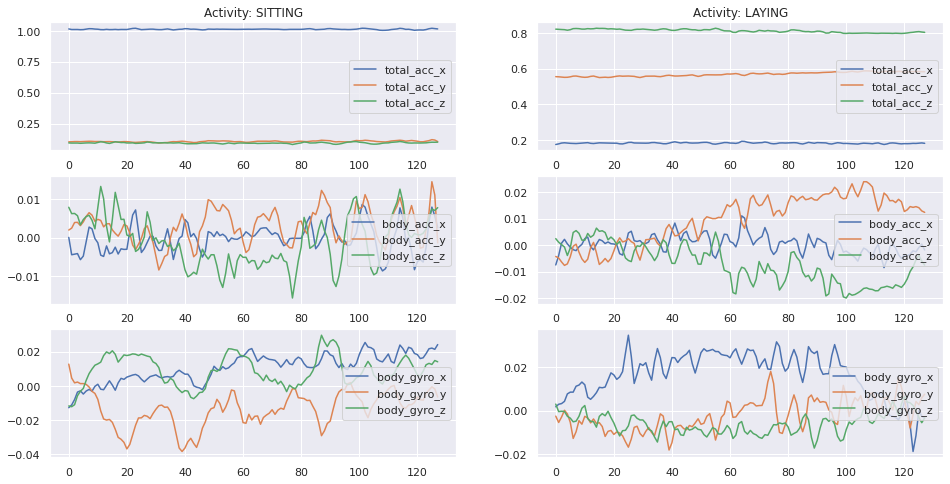

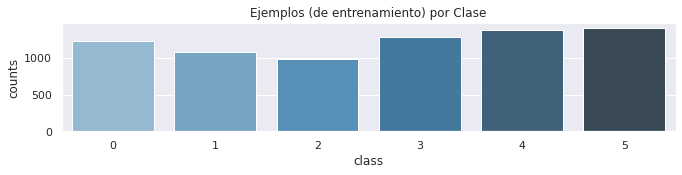

In [ ]:
#print(np.max(X_train))
print("Clases encontradas: ", np.unique(Y_train))

import matplotlib.pyplot as plt

rnd_idx_1 = np.random.randint(0,len(X_train))
rnd_idx_2 = np.random.randint(0,len(X_train))

class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

fig, ax = plt.subplots(3,2, frameon=False, figsize=(16, 8))
l1, = ax[0,0].plot(X_train[rnd_idx_1,:,0],label='total_acc_x')
l2, = ax[0,0].plot(X_train[rnd_idx_1,:,1],label='total_acc_y')
l3, = ax[0,0].plot(X_train[rnd_idx_1,:,2],label='total_acc_z')
ax[0,0].set_title("Activity: %s"%(class_names[Y_train[rnd_idx_1][0]]))
ax[0,0].legend(loc='right')

ax[1,0].plot(X_train[rnd_idx_1,:,3],label='body_acc_x')
ax[1,0].plot(X_train[rnd_idx_1,:,4],label='body_acc_y')
ax[1,0].plot(X_train[rnd_idx_1,:,5],label='body_acc_z')
ax[1,0].legend(loc='right')


ax[2,0].plot(X_train[rnd_idx_1,:,6],label='body_gyro_x')
ax[2,0].plot(X_train[rnd_idx_1,:,7],label='body_gyro_y')
ax[2,0].plot(X_train[rnd_idx_1,:,8],label='body_gyro_z')
ax[2,0].legend(loc='right')

ax[0,1].plot(X_train[rnd_idx_2,:,0],label='total_acc_x')
ax[0,1].plot(X_train[rnd_idx_2,:,1],label='total_acc_y')
ax[0,1].plot(X_train[rnd_idx_2,:,2],label='total_acc_z')
ax[0,1].set_title("Activity: %s"%(class_names[Y_train[rnd_idx_2][0]]))
ax[0,1].legend(loc='right')

ax[1,1].plot(X_train[rnd_idx_2,:,3],label='body_acc_x')
ax[1,1].plot(X_train[rnd_idx_2,:,4],label='body_acc_y')
ax[1,1].plot(X_train[rnd_idx_2,:,5],label='body_acc_z')
ax[1,1].legend(loc='right')

ax[2,1].plot(X_train[rnd_idx_2,:,6],label='body_gyro_x')
ax[2,1].plot(X_train[rnd_idx_2,:,7],label='body_gyro_y')
ax[2,1].plot(X_train[rnd_idx_2,:,8],label='body_gyro_z')
ax[2,1].legend(loc='right')


aux_df = pd.DataFrame()
aux_df['class'] = Y_train[:,0]
aux_df = aux_df.groupby(['class']).size().reset_index(name='counts')

fig, ax = plt.subplots(figsize=(11,2),nrows=1)
sns.barplot(data=aux_df , x='class', y='counts',palette="Blues_d",ax=ax)
ax.set_title('Ejemplos (de entrenamiento) por Clase')
plt.show()

# Baseline: Red Feed-Forward



## Modelo

Dado que una red feed-forward no está diseñada para procesar secuencias, sino vectores de atributos, tendremos que poner las diferentes series en un gran vector de atributos, ignorando el hecho de que una serie corresponde a una medición del mismo atributo (por ejemplo aceleración en el eje $x$) en diferentes instantes de tiempo.

Si cada actividad estaba descrita por una secuencia de 128 x 9 valores, obtendremos un vector de atributos de 1152 dimensiones. 

Como se trata de un problema de clasificación con 6 categorías posibles, nuestra red debe tener exactamente 6 neuronas de salida que nos entregarán las probabilidades que asigna la red a cada una de las categorías cuando entra una determinada señal.


In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense

n_train,time_steps,n_features = X_train.shape
n_test,time_steps,n_features = X_test.shape

#Transformaremos las 9 secuencias que describen 1 movimiento en un vector de 1152 dimensioness
XFlatten_train = np.reshape(X_train,(n_train,time_steps*n_features)) #X flattened
XFlatten_test = np.reshape(X_test,(n_test,time_steps*n_features)) #X flattened

print(XFlatten_train.shape)
n_total_features = XFlatten_train.shape[1]
n_classes = len(np.unique(Y_train))
print("NUMERO DE ATRIBUTOS:", n_total_features, "NUMERO DE CLASES:",n_classes)

def create_fnn(n_classes,n_total_features):
  model = Sequential()
  
  model.add(Dense(100,input_dim=n_total_features))
  model.add(Activation('relu'))
  #model.add(Dropout(rate=0.5))

  model.add(Dense(50))
  model.add(Activation('relu'))
  #model.add(Dropout(rate=0.5))

  #model.add(Dense(25))
  #model.add(Activation('relu'))
  #model.add(Dropout(rate=0.5))
  
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))
  
  return model

fnn = create_fnn(n_classes,n_total_features)
fnn.summary()

(7352, 1152)
NUMERO DE ATRIBUTOS: 1152 NUMERO DE CLASES: 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               115300    
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0         
Total params: 120,656
Trainable params: 120,656
Non-trainable p

## Pre-procesamiento

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=len(Y_test), random_state=10)

XFlatten_train = np.reshape(X_train,(len(X_train),time_steps*n_features)) #X flattened
XFlatten_val = np.reshape(X_val,(len(X_val),time_steps*n_features)) #X flattened
XFlatten_test = np.reshape(X_test,(len(X_test),time_steps*n_features)) #X flattened

class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
class_codes = np.unique(Y_train)

Ye_train = to_categorical(Y_train)
Ye_val = to_categorical(Y_val)
Ye_test = to_categorical(Y_test)


print(XFlatten_train.shape,Ye_train.shape)
print(XFlatten_val.shape,Ye_val.shape)
print(XFlatten_test.shape,Ye_test.shape)


(4405, 1152) (4405, 6)
(2947, 1152) (2947, 6)
(2947, 1152) (2947, 6)


## Monitor de Desempeño en el Conjunto de Pruebasa

In [ ]:
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

class TestSetMonitor(tf.keras.callbacks.Callback):
  
  def __init__(self, validation_data):
    
    super(TestSetMonitor, self).__init__()
    self.validation_data = validation_data
    self.history = None
    
  def on_epoch_end(self, epoch, logs=None):
    
    if self.history == None:
      self.history = {}
      for metric in self.model.metrics:
        self.history[metric.name]  = []

    if (epoch + 1) % 1 == 0:
      
      metric_names = ['{}_{}'.format('epoch', metric.name) for metric in self.model.metrics]
      scores = self.model.evaluate(x=self.validation_data[0], y=self.validation_data[1],verbose=0)
      
      for metric, score in zip(self.model.metrics, scores):
          self.history[metric.name].append(score)

tm = TestSetMonitor((XFlatten_test, Ye_test))


## Entrenamiento

In [ ]:
from keras.optimizers import Adam

fnn = create_fnn(n_classes,n_total_features)

optimizer = Adam()

fnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 64
n_epochs = 30

#history = fnn.fit(XFlatten_train,Ye_train,epochs=n_epochs,batch_size=batch_size,verbose=1,validation_data=(XFlatten_val, Ye_val))

history = fnn.fit(XFlatten_train,Ye_train,epochs=n_epochs,batch_size=batch_size,verbose=1,validation_data=(XFlatten_val, Ye_val),callbacks = [tm])


Epoch 1/30
69/69 [==============================] - 14s 13ms/step - loss: 1.0968 - accuracy: 0.5963 - val_loss: 0.4673 - val_accuracy: 0.8453
Epoch 2/30
69/69 [==============================] - 0s 4ms/step - loss: 0.3650 - accuracy: 0.8954 - val_loss: 0.2736 - val_accuracy: 0.9087
Epoch 3/30
69/69 [==============================] - 0s 4ms/step - loss: 0.2072 - accuracy: 0.9390 - val_loss: 0.2288 - val_accuracy: 0.9213
Epoch 4/30
69/69 [==============================] - 0s 4ms/step - loss: 0.1479 - accuracy: 0.9521 - val_loss: 0.2388 - val_accuracy: 0.9104
Epoch 5/30
69/69 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.9547 - val_loss: 0.2123 - val_accuracy: 0.9131
Epoch 6/30
69/69 [==============================] - 0s 5ms/step - loss: 0.1286 - accuracy: 0.9520 - val_loss: 0.1915 - val_accuracy: 0.9243
Epoch 7/30
69/69 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.9562 - val_loss: 0.2093 - val_accuracy: 0.9172
Epoch 8/30
69/69 [

## Evaluación


Es importante examinar la evolución del aprendizaje de la red durante el entrenamiento, tanto para diagnosticar convergencia como un posible sobre-ajuste (over-fitting).


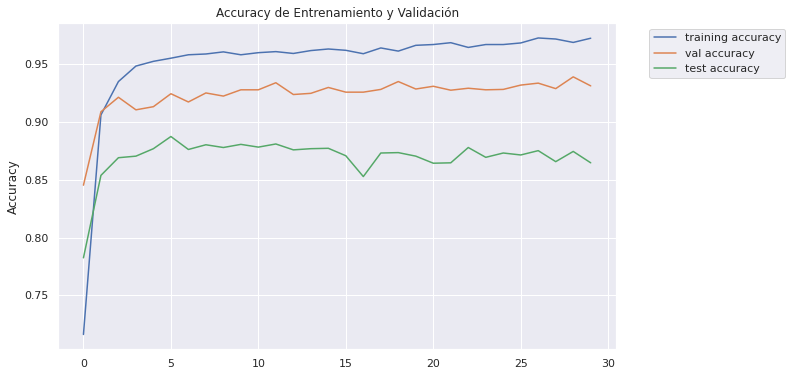

In [ ]:
history_accuracy_train = history.history['accuracy']
history_accuracy_val = history.history['val_accuracy']

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
p1, = ax.plot(history_accuracy_train,label='training accuracy')
p2, = ax.plot(history_accuracy_val,label='val accuracy')

if tm.history is not None:
  p3, = ax.plot(tm.history['accuracy'],label='test accuracy')
  plt.legend(handles=[p1, p2, p3], bbox_to_anchor=(1.05, 1), loc='upper left')
else:
  plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy de Entrenamiento y Validación")

plt.show()



Podemos revisar también cómo se desempeña la red en cada una de las 6 clases para determinar si hay una que le cause más problemas que otra.


In [ ]:
from matplotlib import pyplot as plt
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Arreglo de Probabilidades tiene forma:  (2947, 6)
Al tomar la clase con mayor probabilidad:  (2947,)


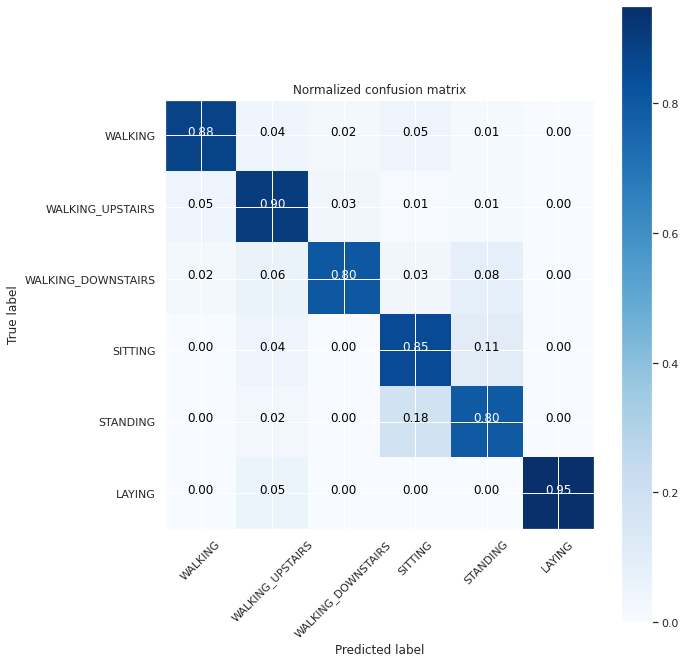

In [ ]:
prob_predictions = fnn.predict(XFlatten_test)

print("Arreglo de Probabilidades tiene forma: ", prob_predictions.shape)

predictions = np.argmax(prob_predictions, axis=1)

print("Al tomar la clase con mayor probabilidad: ", predictions.shape)

groundtruth = Y_test.ravel()

from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(groundtruth, predictions, labels=range(n_classes))

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



# Red Recurrente

## Repaso de la Teoría

<img width='700'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/seq_learning.pdf'>



### Mecanismo

Denotemos por $x = x_1,x_2,\ldots,x_T$ la secuencia de valores que describe cada movimiento. La peculiaridad de una red recurrente respecto de otros modelos profundos es que esta red procesará los elementos de la secuencia $x_i$ uno a la vez, modificando su estado interno o ``memoria'' para recordar  características que ella considera relevantes para hacer una clasificación.

En el tiempo $t=1$ la red observa/consume $x_1 \in \mathbb{R}^9$, cambia su estado interno de $h_0 \in \mathbb{R}^H$ (estado inicial) al estado $h_1 \in \mathbb{R}^H$ dependiendo de lo que vió, y eventualmente emite una salida $y_1$. En nuestro problema, sólo nos interesa la salida de la red después de haber visto toda la secuencia.

En el tiempo $t=2$, la red observa/consume $x_2 \in \mathbb{R}^9$ y cambia su estado interno de $h_1 \in \mathbb{R}^H$ a $h_2 \in \mathbb{R}^H$. Esta vez, su estado interno ya no depende sólo de lo que ha visto en ese momento (como ocurriría con una red feed-forward) sino que depende además de lo que haya visto también en el $t=1$ a través de su estado interno $h_1$. Como en el paso anterior, la red puede emitir un resultado a partir de su nuevo estado interno, pero para la tarea que queremos resolver no es necesario.

En el tiempo $t=3$, la red observa/consume $x_3$. Sin embargo, su comportamiento estará determinado tanto de esa observación como del estado oculto $h_2$ en que se encuentra. Como ese estado oculto depende de $x_2$ e indirectamente de $x_1$ a través de $h_1$, tendremos que el comportamiento de la red en $t=3$ dependerá de $x_1$, $x_2$ y $x_3$.

Y así sucesivamente. Cuando la red llega al final de la serie/sequencia en $t=T$, su estado interno $h_T$ será determinado de la última cosa que haya visto ($x_T$), pero también de toda la memoria que haya acumulado de la secuencia hasta ese momento. En este momento, la red emitirá una salida $y_T$ que interpretaremos como la predicción!

En ecuaciones tenemos

\begin{equation*}
\begin{aligned}[c]
y_1 &= f(x_1,h_0)\\
y_2 &= f(x_2,h_1)\\
y_3 &= f(x_2,h_2)\\
\cdots\\
y_T &= f(x_T,h_{T-1})\\
\end{aligned}
\qquad
\qquad
\begin{aligned}[c]
h_1 &= g(x_1,h_0)\\
h_2 &= g(x_2,h_1)\\
h_3 &= g(x_3,h_2)\\
\cdots\\
h_T &= g(x_T,h_{T-1})\\
\end{aligned}
\end{equation*}

Gráficamente tenemos lo siguiente:


<img width='1000'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/basic_pics_rnn_1.pdf'>




El diagrama se puede simplificar representanto en una misma capa, tanto las neuronas que la red usa para "recordar" ($h$) como aquellas que usa para transformar los datos que lee en ese momento ($a$). 





<img width='800'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/basic_pics_rnn_2.pdf'>




Para implementar las capas de esta red, podemos emplear cualquiera de las que hemos estudiado (densas o convolucionales). Normalmente se emplean las primeras:

<img width='800'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/basic_pics_rnn_3.pdf'>




El diagrama que resume el mecanismo que aplica la red a la secuencia se puede simplificar aún más si convenimos que los arcos representan un retardo de $1$ unidad de tiempo en el procesamiento de información. Con esta convención, el efecto de $h$ en el tiempo $t$ sobre $h$ en el tiempo $t+1$ se puede representar usando un loop (un arco digirido desde $h$ hacia sí misma). Como el nuevo grafo tiene ciclos, la red se denomina "recurrente".

<img width='400'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/basic_pics_rnn_4.pdf'>




La representación de más arriba, donde exponemos los diferentes instantes de tiempo explícitamente se denomina la ''representación desenrollada'' de la red recurrente y nos permite ver más claramente cómo podemos entrenar este modelo en la práctica: simple back-propagation, pero ahora en el tiempo!

## Modelo Estándar (uni-direccional)



### Construcción

Dado que una red recurrente sí está diseñada para procesar secuencias, podemos mantener la forma de nuestras 9 secuencias de entrada (128 *time steps*).


In [ ]:
class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
class_codes = np.unique(Y_train)#0,1,2 ... 5
n_classes = len(class_codes)#6

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, SimpleRNN

def create_LSTM(n_timesteps, n_features, n_classes):
  
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
  model.add(Dropout(rate=0.5))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
  return model
  
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

LSTM_uni = create_LSTM(n_timesteps, n_features, n_classes)
LSTM_uni.summary()

print("\nLSTM Created")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 126       
Total params: 46,146
Trainable params: 46,146
Non-trainable params: 0
_________________________________________________________________

LSTM Created


### Pre-procesamiento

In [ ]:
from tensorflow.keras.utils import to_categorical
 
Ye_train = to_categorical(Y_train)
Ye_val = to_categorical(Y_val)
Ye_test = to_categorical(Y_test)

print(X_train.shape,Ye_train.shape)
print(X_val.shape,Ye_val.shape)
print(X_test.shape,Ye_test.shape)

tm_uni = TestSetMonitor((X_test, Ye_test))


(4405, 128, 9) (4405, 6)
(2947, 128, 9) (2947, 6)
(2947, 128, 9) (2947, 6)


### Entrenamiento

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM

n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
LSTM_uni = create_LSTM(n_timesteps, n_features, n_classes)

#history_LSTM_uni = LSTM_uni.fit(X_train, Ye_train, epochs=30, batch_size=32, verbose=1,validation_data=(X_test, Ye_test))

history_LSTM_uni = LSTM_uni.fit(X_train, Ye_train, epochs=30, batch_size=32, verbose=1,validation_data=(X_val, Ye_val), callbacks = [tm_uni])



Epoch 1/30
138/138 [==============================] - 10s 14ms/step - loss: 1.4757 - accuracy: 0.3577 - val_loss: 1.0201 - val_accuracy: 0.5490
Epoch 2/30
138/138 [==============================] - 1s 9ms/step - loss: 1.1787 - accuracy: 0.4967 - val_loss: 1.0656 - val_accuracy: 0.4920
Epoch 3/30
138/138 [==============================] - 1s 10ms/step - loss: 0.8992 - accuracy: 0.6075 - val_loss: 0.6888 - val_accuracy: 0.7160
Epoch 4/30
138/138 [==============================] - 1s 10ms/step - loss: 0.6940 - accuracy: 0.6973 - val_loss: 0.7460 - val_accuracy: 0.6871
Epoch 5/30
138/138 [==============================] - 1s 9ms/step - loss: 0.6561 - accuracy: 0.6962 - val_loss: 0.4965 - val_accuracy: 0.7781
Epoch 6/30
138/138 [==============================] - 2s 12ms/step - loss: 0.5251 - accuracy: 0.8013 - val_loss: 0.3601 - val_accuracy: 0.8724
Epoch 7/30
138/138 [==============================] - 2s 12ms/step - loss: 0.3447 - accuracy: 0.8920 - val_loss: 0.2569 - val_accuracy: 0.9141


### Evaluación

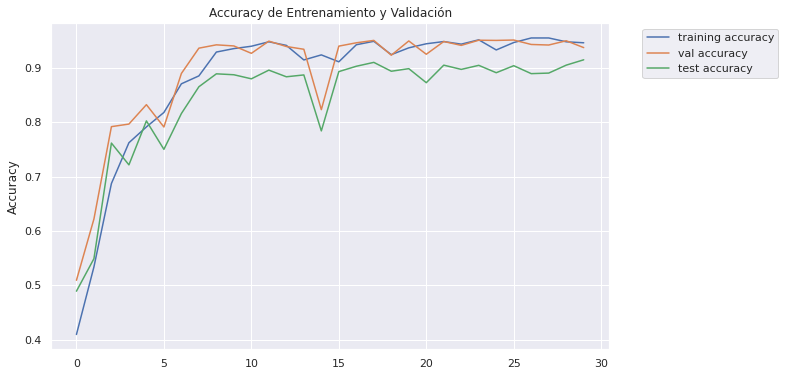

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
p1, = ax.plot(history_LSTM_uni.history['accuracy'],label='training accuracy')
p2, = ax.plot(history_LSTM_uni.history['val_accuracy'],label='val accuracy')

if tm_uni.history is not None:
  p3, = ax.plot(tm_uni.history['accuracy'],label='test accuracy')
  plt.legend(handles=[p1, p2, p3], bbox_to_anchor=(1.05, 1), loc='upper left')
else:
  plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy de Entrenamiento y Validación")

plt.show()



In [ ]:
from matplotlib import pyplot as plt
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print("\n")
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

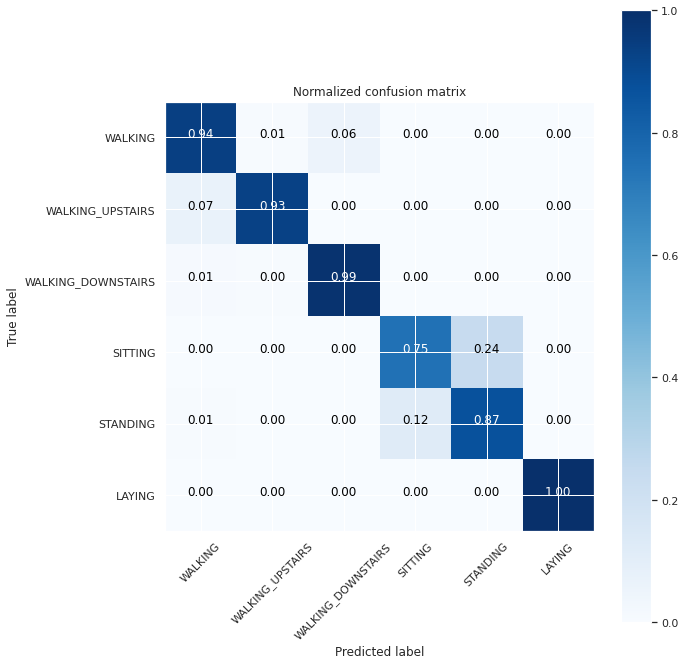

In [ ]:
prop_predictions = LSTM_uni.predict(X_test)
#print(prop_predictions.shape)

predictions = np.argmax(prop_predictions, axis=1)
diff_predictions = np.unique(predictions)

groundtruth = Y_test.ravel()

from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(groundtruth, predictions, labels=range(n_classes))

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


## Modelo Bidireccional

### Construcción


In [ ]:
class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
class_codes = np.unique(Y_train)
n_classes = len(class_codes)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional

def create_LSTM_Bidir(n_timesteps, n_features, n_classes):
  
  model = Sequential()
  model.add(Bidirectional(LSTM(50), input_shape=(n_timesteps,n_features) )) #recurrent_dropout=0.25
  model.add(Dropout(rate=0.5))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
  return model
  
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

LSTM_bi = create_LSTM_Bidir(n_timesteps, n_features, n_classes)
LSTM_bi.summary()

print("LSTM Bidireccional Creada")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               24000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 126       
Total params: 26,146
Trainable params: 26,146
Non-trainable params: 0
_________________________________________________________________
LSTM Bidireccional Creada


### Pre-procesamiento

In [ ]:
from tensorflow.keras.utils import to_categorical
 
Ye_train = to_categorical(Y_train)
Ye_val = to_categorical(Y_val)
Ye_test = to_categorical(Y_test)

print(X_train.shape,Ye_train.shape)
print(X_val.shape,Ye_val.shape)
print(X_test.shape,Ye_test.shape)

tm_bi = TestSetMonitor((X_test, Ye_test))


(4405, 128, 9) (4405, 6)
(2947, 128, 9) (2947, 6)
(2947, 128, 9) (2947, 6)


### Entrenamiento

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM


n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
LSTM_bi = create_LSTM_Bidir(n_timesteps, n_features, n_classes)
LSTM_bi.summary()


#history_LSTM_bi = LSTM_bi.fit(X_train, Ye_train, epochs=30, batch_size=32, verbose=1,validation_data=(X_test, Ye_test))

history_LSTM_bi = LSTM_bi.fit(X_train, Ye_train, epochs=30, batch_size=32, verbose=1,validation_data=(X_val, Ye_val),  callbacks = [tm_bi])





Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 100)               24000     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_113 (Dense)            (None, 6)                 126       
Total params: 26,146
Trainable params: 26,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
138/138 [==============================] - 6s 22ms/step - loss: 1.5102 - accuracy: 0.3746 - val_loss: 1.0652 - val_accuracy: 0.5779
Epoch 2/30
138/138 [==============================] - 2s 14ms/step - loss: 1.0185 - accuracy: 0.5577 - v

### Evaluación

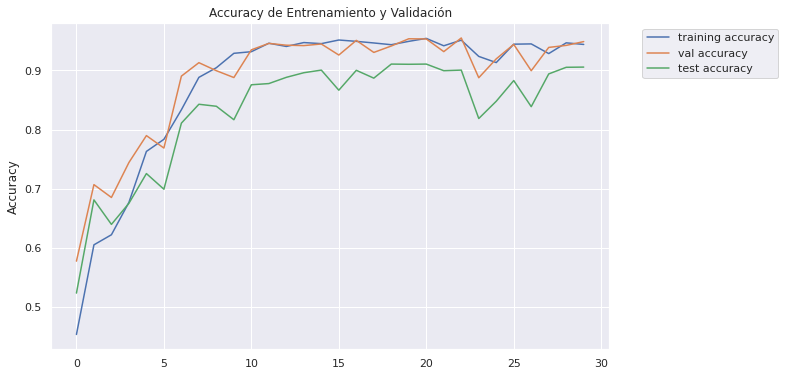

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
p1, = ax.plot(history_LSTM_bi.history['accuracy'],label='training accuracy')
p2, = ax.plot(history_LSTM_bi.history['val_accuracy'],label='val accuracy')

if tm_bi.history is not None:
  p3, = ax.plot(tm_bi.history['accuracy'],label='test accuracy')
  plt.legend(handles=[p1, p2, p3], bbox_to_anchor=(1.05, 1), loc='upper left')
else:
  plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy de Entrenamiento y Validación")

plt.show()

